Mount Google Drive to Notebook


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls drive/MyDrive/THE\ Project\ Dataset


'tcc_ceds_music (1).gsheet'   training_data-tcc_ceds_music.gsheet
 tcc_ceds_music.csv	      validation_data-tcc_ceds_music.gsheet
 tcc_ceds_music.gsheet


**Set-Up PySpark for the session**

In [4]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget https://dlcdn.apache.org/spark/spark-3.3.4/spark-3.3.4-bin-hadoop3.tgz
!tar -xvf spark-3.3.4-bin-hadoop3.tgz
!pip install findspark

import os
import os.path
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.4-bin-hadoop3"

import findspark
findspark.init()
findspark.find()
import pyspark
sc = pyspark.SparkContext()

--2023-12-17 23:16:53--  https://dlcdn.apache.org/spark/spark-3.3.4/spark-3.3.4-bin-hadoop3.tgz
Resolving dlcdn.apache.org (dlcdn.apache.org)... 151.101.2.132, 2a04:4e42::644
Connecting to dlcdn.apache.org (dlcdn.apache.org)|151.101.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 299467603 (286M) [application/x-gzip]
Saving to: ‘spark-3.3.4-bin-hadoop3.tgz’

spark-3.3.4-bin-had 100%[===================>] 285.59M   164MB/s    in 1.7s    

2023-12-17 23:18:11 (164 MB/s) - ‘spark-3.3.4-bin-hadoop3.tgz’ saved [299467603/299467603]

spark-3.3.4-bin-hadoop3/
spark-3.3.4-bin-hadoop3/R/
spark-3.3.4-bin-hadoop3/R/lib/
spark-3.3.4-bin-hadoop3/R/lib/sparkr.zip
spark-3.3.4-bin-hadoop3/R/lib/SparkR/
spark-3.3.4-bin-hadoop3/R/lib/SparkR/worker/
spark-3.3.4-bin-hadoop3/R/lib/SparkR/worker/worker.R
spark-3.3.4-bin-hadoop3/R/lib/SparkR/worker/daemon.R
spark-3.3.4-bin-hadoop3/R/lib/SparkR/tests/
spark-3.3.4-bin-hadoop3/R/lib/SparkR/tests/testthat/
spark-3.3.4-bin-hadoop3/

**Pre-processing of data from dataset**


In [ ]:
from pyspark.sql import SparkSession
import re
import pandas as pd

spark = SparkSession.builder.appName("example").getOrCreate() #Create Spark Session


#Create a Pandas Dataframe
df = pd.read_csv('/content/drive/MyDrive/THE Project Dataset/tcc_ceds_music.csv')

#Remove all the unwanted commas from the values in each cell specified; this is to allow for proper parsing of the CSV file
df["artist_name"] = df["artist_name"].replace(",", " ", regex = True)
df["track_name"] = df["track_name"].replace(",", " ", regex = True)
df["lyrics"] = df["lyrics"].replace(",", " ", regex = True)

spark_df = spark.createDataFrame(df)
#spark_df.show()

musicRDD = spark_df.rdd
#print(musicRDD.take(5))
musicRDD.cache()


def extractFields(musicRDD_Record):

  """
  -Create a pair-RDD.
  -Format of the Pair-RDD (Genre, (danceability, loudness, acousticness, intrumentalness, valence, energy))

  Parameters
  -----------

  musicRDD_Record : str
    - A comma-separated string containing all relevant data about a song; each column of data is separated by commas

  Return Value
  ------------
  Returns a pair-RDD that has the genre of the song as its key and the values are numbers that determine how danceable is the song, how loud the song is, etc.
  """

  return (musicRDD_Record[4], musicRDD_Record[23], musicRDD_Record[24], musicRDD_Record[25], musicRDD_Record[26], musicRDD_Record[27], musicRDD_Record[28])



def extractAllFields(musicRDD_Record):

  """
  -Create an RDD.
  -Format of the PRDD (All features of the song that has numerical value)

  Parameters
  -----------

  musicRDD_Record : str
    - A comma-separated string containing all relevant data about a song; each column of data is separated by commas

  Return Value
  ------------
  Returns an RDD that has all features of the song that have a numerical value
  """


  return (musicRDD_Record[4], musicRDD_Record[7], musicRDD_Record[8],musicRDD_Record[9],musicRDD_Record[10],musicRDD_Record[11],musicRDD_Record[12],musicRDD_Record[13],musicRDD_Record[14],
          musicRDD_Record[15], musicRDD_Record[16],musicRDD_Record[17],musicRDD_Record[18],musicRDD_Record[19],musicRDD_Record[20],musicRDD_Record[21],musicRDD_Record[22],
          musicRDD_Record[23], musicRDD_Record[24], musicRDD_Record[25], musicRDD_Record[26], musicRDD_Record[27], musicRDD_Record[28])



song_dataRDD = musicRDD.map(extractFields) #Contains the genre as a key and then the features to be used in the ML model as values

#Convert song_dataRDD into DataFrame; For testing purposes
df1 = song_dataRDD.toDF(["genre","danceability", "loudness", "acousticness", "instrumentalness", "valence", "energy"])
df1.show()

print(song_dataRDD.count()) # expected count: 28372 (total number of records)
print(song_dataRDD.take(20))


more_songdataRDD = musicRDD.map(extractAllFields) #Contains all features in the song that have a numerical value
print(more_songdataRDD.count()) # expected count: 28372 (total number of records)
print(more_songdataRDD.take(1))

song_dataRDD.cache()
more_songdataRDD.cache()

/content/spark-3.3.4-bin-hadoop3/python/pyspark/sql/pandas/conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/content/spark-3.3.4-bin-hadoop3/python/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


+-----+------------------+------------------+------------------+--------------------+------------------+------------------+
|genre|      danceability|          loudness|      acousticness|    instrumentalness|           valence|            energy|
+-----+------------------+------------------+------------------+--------------------+------------------+------------------+
|  pop|0.3577385465179248|0.4541189139296976|0.9979919658553876|   0.901821862348178|0.3394476504534212|0.1371101880258922|
|  pop|0.3317448283331528|       0.647539933|0.9548192317462166|1.528340080971659...|0.3250206100577081|0.2632402533492537|
|  pop|0.4562980613018521|       0.585288311|0.8403612855032989|                 0.0|0.3518136850783182|0.1391122525548345|
|  pop|0.6869923101917037|0.7444042765941081|       0.083934823|  0.1993927125506072|0.7753503709810387|0.7437357402953926|
|  pop|0.2916711794649627|0.6464887316360279|0.9759035902646488|          2.45951E-4|       0.597073372|0.3943754799949707|
|  pop| 

PythonRDD[43] at RDD at PythonRDD.scala:53

Splitting data into training data and test data

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import rand

# Importing this doesn't work either
# from pyspark.sql.functions import median

# Create a Spark session
spark = SparkSession.builder.appName("example").getOrCreate()

# convert RDD to a dataframe


df = more_songdataRDD.toDF(["Genre","dating","violence","world/life","night/time","shake the audience","family/gospel","romantic","communication","obscene","music","movement/places",
                      "light/visual perceptions","family/spiritual","like/girls","sadness","feelings","danceability","loudness","acousticness","instrumentalness","valence","energy"])
# df.show(truncate=False)

# Split data into training data and test data (split: 70% training, 30% test).
# Can configure the split, but the hopes is that training data accurately represents
# test data (in hopes model can predict real world data).
training_df, test_df = df.randomSplit(weights=[0.7,0.3], seed=550)

# Show the result
training_df = training_df.orderBy(rand(seed=42))
training_df.show(truncate=False)

test_df = test_df.orderBy(rand(seed=50))
test_df.show(truncate=False)
# training_rdd = training_df.rdd
# test_rdd = test_df.rdd
# print("training: %d" % training_rdd.count())
# print("test: %d" % test_rdd.count())


+------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+---------------------+------------------+------------------+
|Genre |dating            |violence          |world/life        |night/time        |shake the audience|family/gospel     |romantic          |communication     |obscene           |music             |movement/places   |light/visual perceptions|family/spiritual  |like/girls        |sadness           |feelings          |danceability      |loudness          |acousticness      |instrumentalness     |valence           |energy            |
+------+------------------+------------------+------------------+------------------+------------------+------------------+------

Finding the mean, etc.. for each set category for the training data

In [ ]:
from pyspark.sql import functions as F

song_data_features = ["Genre","dating","violence","world/life","night/time","shake the audience","family/gospel","romantic","communication","obscene","music","movement/places",
                      "light/visual perceptions","family/spiritual","like/girls","sadness","feelings","danceability","loudness","acousticness","instrumentalness","valence","energy"]

#Calculate the mean, mode, etc., for each feature that has a numerical value
song_data_features_rdd = training_df.rdd.map(lambda x: (x[0:23]))
song_data_features_df = song_data_features_rdd.toDF(song_data_features)
song_data_features_df.show()

mean_df = song_data_features_df.groupBy("Genre").mean()
mean_df.show()

min_df = song_data_features_df.groupBy("Genre").min()
min_df.show()

max_df = song_data_features_df.groupBy("Genre").max()
max_df.show()

skip = True #Skip first column of song_data_features when calculating standard deviation

for col in song_data_features:
  if(skip):
    skip = False
    continue

  stddev_df = song_data_features_df.groupBy("Genre").agg(F.stddev(col))
  stddev_df.show()



+------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+--------------------+------------------+------------------+
| Genre|            dating|          violence|        world/life|        night/time|shake the audience|     family/gospel|          romantic|     communication|           obscene|             music|   movement/places|light/visual perceptions|  family/spiritual|        like/girls|           sadness|          feelings|      danceability|          loudness|      acousticness|    instrumentalness|           valence|            energy|
+------+------------------+------------------+------------------+------------------+------------------+------------------+--------

**Filter out the feature we want to use**


In [ ]:
#Filter out the feature we want to use for ML Models
training_df.printSchema()

unwanted_features = song_data_features.copy()

columns = ["Genre","obscene", "music", "valence", "energy"] #Features to be used in the ML model; change accordingly

#Remove Unwanted Features
for i in columns:
  unwanted_features.remove(i)

#print(unwanted_features)

training_df = training_df.drop(*unwanted_features)
training_df.printSchema()

test_df = test_df.drop(*unwanted_features)
test_df.printSchema()

root
 |-- Genre: string (nullable = true)
 |-- dating: double (nullable = true)
 |-- violence: double (nullable = true)
 |-- world/life: double (nullable = true)
 |-- night/time: double (nullable = true)
 |-- shake the audience: double (nullable = true)
 |-- family/gospel: double (nullable = true)
 |-- romantic: double (nullable = true)
 |-- communication: double (nullable = true)
 |-- obscene: double (nullable = true)
 |-- music: double (nullable = true)
 |-- movement/places: double (nullable = true)
 |-- light/visual perceptions: double (nullable = true)
 |-- family/spiritual: double (nullable = true)
 |-- like/girls: double (nullable = true)
 |-- sadness: double (nullable = true)
 |-- feelings: double (nullable = true)
 |-- danceability: double (nullable = true)
 |-- loudness: double (nullable = true)
 |-- acousticness: double (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- valence: double (nullable = true)
 |-- energy: double (nullable = true)

root
 |-- Genr

Charts


+-------+-----------+
|  genre|Total_Count|
+-------+-----------+
|    pop|       7042|
|  blues|       4604|
|country|       5445|
|   jazz|       3845|
|hip hop|        904|
|   rock|       4034|
| reggae|       2498|
+-------+-----------+



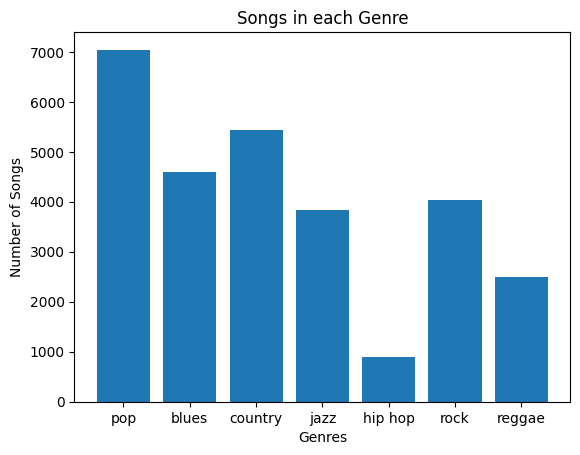

+----+-----------+
|Year|Total_Count|
+----+-----------+
|1950|         51|
|1951|         58|
|1952|         60|
|1953|         48|
|1954|        109|
|1955|        106|
|1956|        200|
|1957|        237|
|1958|        287|
|1959|        312|
|1960|        274|
|1961|        271|
|1962|        309|
|1963|        369|
|1964|        383|
|1965|        356|
|1966|        343|
|1967|        394|
|1968|        388|
|1969|        322|
+----+-----------+
only showing top 20 rows



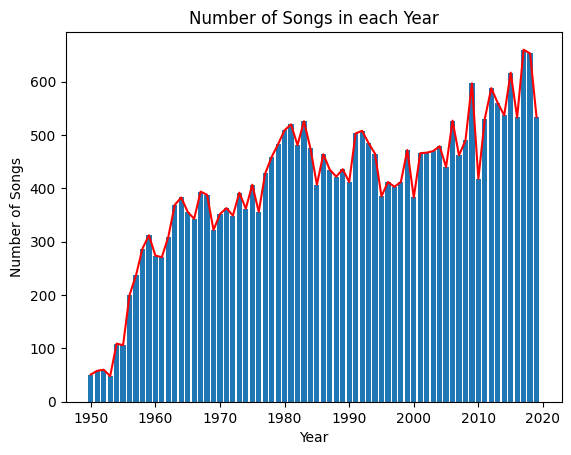

+----------+-----------+
|     Topic|Total_Count|
+----------+-----------+
|  romantic|       1524|
|     music|       2303|
|  violence|       5710|
|  feelings|        612|
|   sadness|       6096|
|night/time|       1825|
|   obscene|       4882|
|world/life|       5420|
+----------+-----------+



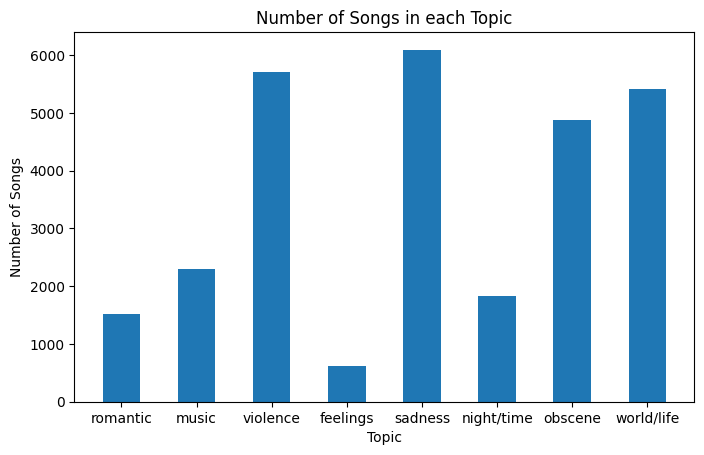

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql.functions import lit

spark = SparkSession.builder.appName("plots").getOrCreate()

#Counting the number of songs that fall into each genre
columns = ["genre", "categories"] # "categories" are the different features
totals_df = song_dataRDD.toDF(columns).withColumn("Count", lit(1)).drop("categories", "_3", "_4", "_5", "_6", "_7").groupBy("genre").sum().withColumnRenamed("sum(Count)", "Total_Count")
totals_df.show()

x_labels = []
y_labels = []

for col in totals_df.collect():
  x_labels.append(col[0])
  y_labels.append(col[1])

plt.bar(x_labels, y_labels)
plt.title("Songs in each Genre")
plt.xlabel("Genres")
plt.ylabel("Number of Songs")
plt.show()



#Counting the number of songs in each year
years_rdd = musicRDD.map(lambda x: (x[3], 1))
columns = ["Year","Count"]
years_df = years_rdd.toDF(columns).groupBy("Year").sum("Count").withColumnRenamed("sum(Count)", "Total_Count").sort("Year", ascending=[True])
years_df.show()


x_labels = []
y_labels = []

for col in years_df.collect():
  x_labels.append(col[0])
  y_labels.append(col[1])

plt.plot(x_labels, y_labels, color='red')
plt.bar(x_labels, y_labels)
plt.title("Number of Songs in each Year")
plt.xlabel("Year")
plt.ylabel("Number of Songs")
plt.show()


#Counting the number of songs that belong to each topic
topics_rdd = musicRDD.map(lambda x: (x[29], 1))
columns = ["Topic","Count"]
topics_df = topics_rdd.toDF(columns).groupBy("Topic").sum("Count").withColumnRenamed("sum(Count)", "Total_Count")
topics_df.show()

x_labels = []
y_labels = []

for col in topics_df.collect():
  x_labels.append(col[0])
  y_labels.append(col[1])

plt.figure(figsize=(8,4.8))
plt.bar(x_labels, y_labels, width=0.5)
plt.title("Number of Songs in each Topic")
plt.xlabel("Topic")
plt.ylabel("Number of Songs")
plt.show()

**Machine Learning Model**

**1(a) Decision Tree Classifier** Transforming data into acceptable format and training the model

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler


sqlContext = pyspark.SQLContext(sc)

features = ["obscene", "music", "valence", "energy"] #Features to be used in the ML model; Change the features inside according to what you want to use


#Converting Training data into acceptable format for Decision Tree Model

labelIndexer = StringIndexer(inputCol="Genre", outputCol="encoded_genre").fit(training_df)

#pop = 0, country = 1, blues = 2, rock = 3, jazz = 4, reggae = 5, hip hop = 6
encoded_df = labelIndexer.transform(training_df)

encoded_df.groupBy("Genre").count().show()


#Vector Assembler for ML model training
assembler = VectorAssembler(inputCols=features, outputCol = "features")
output = assembler.transform(encoded_df) #Transform assembler into dataframe

model_training_df = output.select("features", "encoded_genre")
model_training_df.show()



#Converting Testing data into acceptable format for Decision Tree Model

labelIndexer = StringIndexer(inputCol="Genre", outputCol="encoded_genre").fit(test_df)
#pop = 0, country = 1, blues = 2, rock = 3, jazz = 4, reggae = 5, hip hop = 6
encoded_df = labelIndexer.transform(test_df)

encoded_df.groupBy("Genre").count().show()


#Vector Assembler for ML model training
assembler = VectorAssembler(inputCols=features, outputCol = "features")
output = assembler.transform(encoded_df) #Transform assembler into dataframe

model_testing_df = output.select("features", "encoded_genre")
model_testing_df.show()


tree_classifier = DecisionTreeClassifier(labelCol = "encoded_genre").fit(model_training_df)

/content/spark-3.3.4-bin-hadoop3/python/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


+-------+-----+
|  Genre|count|
+-------+-----+
|    pop| 5051|
|  blues| 3240|
|country| 3802|
|   jazz| 2665|
|hip hop|  626|
|   rock| 2877|
| reggae| 1772|
+-------+-----+

+--------------------+-------------+
|            features|encoded_genre|
+--------------------+-------------+
|[0.001814882,0.00...|          4.0|
|[0.001196172,0.43...|          0.0|
|[0.001503759,0.00...|          2.0|
|[0.001283697,0.26...|          4.0|
|[0.001879699,0.00...|          4.0|
|[0.001283697,0.09...|          2.0|
|[0.074885498,5.21...|          2.0|
|[0.44383487837266...|          0.0|
|[5.48246E-4,5.482...|          2.0|
|[0.002024292,0.00...|          0.0|
|[0.47810000562207...|          4.0|
|[0.004784689,0.00...|          5.0|
|[0.00122399,0.001...|          0.0|
|[0.001283697,0.00...|          0.0|
|[0.001052632,0.00...|          4.0|
|[0.050314748,9.07...|          5.0|
|[0.65982906081455...|          0.0|
|[0.036483414,0.60...|          0.0|
|[9.07441E-4,9.074...|          4.0|
|[0.01052

**1(b) Using Test data set on Decision Tree Model**

In [ ]:
tree_predictions = tree_classifier.transform(model_testing_df) #Input test dataset into model

tree_predictions.show() #Display results (Actual vs Predicted)

accuracy = MulticlassClassificationEvaluator(labelCol="encoded_genre", metricName = "accuracy").evaluate(tree_predictions)
precision = MulticlassClassificationEvaluator(labelCol="encoded_genre", metricName = "weightedPrecision").evaluate(tree_predictions)
importances = tree_classifier.featureImportances
falsePositiveRate = MulticlassClassificationEvaluator(labelCol="encoded_genre", metricName = "weightedFalsePositiveRate").evaluate(tree_predictions)
truePositiveRate = MulticlassClassificationEvaluator(labelCol="encoded_genre", metricName = "weightedTruePositiveRate").evaluate(tree_predictions)
fMeasure = MulticlassClassificationEvaluator(labelCol="encoded_genre", metricName = "weightedFMeasure").evaluate(tree_predictions)
recall = MulticlassClassificationEvaluator(labelCol="encoded_genre", metricName = "weightedRecall").evaluate(tree_predictions)

# Weighted values
print("Accuracy: ",accuracy)
print("Precision: ", precision)

print("Feature Importances: ", importances) #Format: (Number_of_Features, [List_of_indexes], [Weights for each feature])

print("True Positive Rate: ",truePositiveRate)
print("False Positive Rate: ", falsePositiveRate)
print("F-Measure: ", fMeasure)
print("Recall: ", recall)

print("\n\n")

tree_prediction_labels = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0]

for label in sorted(tree_prediction_labels):
  # for multiclass, we can inspect metrics on a per-label basis
  print("Class %s True Positive Rate: %s" % (label, MulticlassClassificationEvaluator(labelCol="encoded_genre", metricName = "truePositiveRateByLabel", metricLabel = label).evaluate(tree_predictions)))
  print("Class %s False Positive Rate: %s" % (label, MulticlassClassificationEvaluator(labelCol="encoded_genre", metricName = "falsePositiveRateByLabel", metricLabel = label).evaluate(tree_predictions)))
  print("Class %s Precision: %s" % (label, MulticlassClassificationEvaluator(labelCol="encoded_genre", metricName = "precisionByLabel", metricLabel = label).evaluate(tree_predictions)))
  print("Class %s Recall: %s" % (label, MulticlassClassificationEvaluator(labelCol="encoded_genre", metricName = "recallByLabel", metricLabel = label).evaluate(tree_predictions)))
  print("Class %s F-Measure: %s" % (label, MulticlassClassificationEvaluator(labelCol="encoded_genre", metricName = "fMeasureByLabel", metricLabel = label).evaluate(tree_predictions)))
  print("\n")

print("Hamming Loss: ", MulticlassClassificationEvaluator(labelCol="encoded_genre", metricName = "hammingLoss").evaluate(tree_predictions))


+--------------------+-------------+--------------------+--------------------+----------+
|            features|encoded_genre|       rawPrediction|         probability|prediction|
+--------------------+-------------+--------------------+--------------------+----------+
|[0.10899971127759...|          1.0|[329.0,640.0,286....|[0.19094602437608...|       1.0|
|[0.001283697,0.00...|          2.0|[1396.0,710.0,866...|[0.29235602094240...|       0.0|
|[0.31595797597796...|          4.0|[1396.0,710.0,866...|[0.29235602094240...|       0.0|
|[5.54017E-4,5.540...|          2.0|[372.0,131.0,218....|[0.28593389700230...|       3.0|
|[0.002392345,0.17...|          1.0|[329.0,640.0,286....|[0.19094602437608...|       1.0|
|[0.001385042,0.09...|          5.0|[179.0,242.0,145....|[0.18607068607068...|       5.0|
|[0.31063986678453...|          5.0|[1396.0,710.0,866...|[0.29235602094240...|       0.0|
|[6.74764E-4,0.088...|          3.0|[987.0,1098.0,613...|[0.25543478260869...|       1.0|
|[0.143416

Training data evaluation metrics

In [ ]:
tree_training_predictions = tree_classifier.transform(model_training_df) #Input training dataset into model


accuracy = MulticlassClassificationEvaluator(labelCol="encoded_genre", metricName = "accuracy").evaluate(tree_training_predictions)
precision = MulticlassClassificationEvaluator(labelCol="encoded_genre", metricName = "weightedPrecision").evaluate(tree_training_predictions)
falsePositiveRate = MulticlassClassificationEvaluator(labelCol="encoded_genre", metricName = "weightedFalsePositiveRate").evaluate(tree_training_predictions)
truePositiveRate = MulticlassClassificationEvaluator(labelCol="encoded_genre", metricName = "weightedTruePositiveRate").evaluate(tree_training_predictions)
fMeasure = MulticlassClassificationEvaluator(labelCol="encoded_genre", metricName = "weightedFMeasure").evaluate(tree_training_predictions)
recall = MulticlassClassificationEvaluator(labelCol="encoded_genre", metricName = "weightedRecall").evaluate(tree_training_predictions)

# Weighted values
print("Accuracy: ",accuracy)
print("Precision: ", precision)
print("True Positive Rate: ",truePositiveRate)
print("False Positive Rate: ", falsePositiveRate)
print("F-Measure: ", fMeasure)
print("Recall: ", recall)

print("\n\n")

Accuracy:  0.31418160035940695
Precision:  0.3268263734996215
True Positive Rate:  0.314181600359407
False Positive Rate:  0.17674426604287155
F-Measure:  0.27600917878074344
Recall:  0.314181600359407





**2(a) Transforming Data to be in a Format acceptable by LogisticRegressionWithLBFGS**

In [ ]:
from pyspark.ml.feature import StringIndexer

sqlContext = pyspark.SQLContext(sc)

# Converting Training data into acceptable format for LogisticRegressionWithLBFGS

labelIndexer = StringIndexer(inputCol="Genre", outputCol="encoded_genre").fit(training_df)

# Encode training and test data
# pop = 0, country = 1, blues = 2, rock = 3, jazz = 4, reggae = 5, hip hop = 6
encoded_train_df = labelIndexer.transform(training_df)
encoded_train_df.groupBy("Genre").count().show()
encoded_train_df.show(truncate=False)

encoded_test_df = labelIndexer.transform(test_df)
encoded_test_df.groupBy("Genre").count().show()
encoded_test_df.show(truncate=False)

#convert to encoded training and test data to RDD
encoded_train_RDD = encoded_train_df.rdd.map(list)
print(encoded_train_RDD.take(1))
print(encoded_train_RDD.collect())
print(encoded_train_RDD.count())

encoded_test_RDD = encoded_test_df.rdd.map(list)
print(encoded_test_RDD.take(1))
print(encoded_test_RDD.collect())
print(encoded_test_RDD.count())

# convert to a proper format for logistical regression
def extractRegressionData(encoded_training_data_RDD):
    """Outputs a string record with the format "encoded genre, obscene, music, valence, energy"
    Args:
        encoded_training_data_RDD: record with the format: "Genre, obscene, music , valence, energy, encoded_genre"

    Returns:
        record with the format "encoded genre, obscene, music, valence, energy
    """

    returnRecord = str(encoded_training_data_RDD[5]) + "," + str(encoded_training_data_RDD[1]) + "," + str(encoded_training_data_RDD[2]) \
                    + ","+ str(encoded_training_data_RDD[3]) + "," + str(encoded_training_data_RDD[4])
    return returnRecord

# format training data
regressionDataRDD = encoded_train_RDD.map(extractRegressionData)
print(regressionDataRDD.take(3))
print(regressionDataRDD.count())

# format test data
regression_test_data_RDD = encoded_test_RDD.map(extractRegressionData)
print(regression_test_data_RDD.take(3))
print(regression_test_data_RDD.count())

+-------+-----+
|  Genre|count|
+-------+-----+
|    pop| 5051|
|  blues| 3240|
|country| 3802|
|   jazz| 2665|
|hip hop|  626|
|   rock| 2877|
| reggae| 1772|
+-------+-----+

+------+------------------+------------------+------------------+------------------+-------------+
|Genre |obscene           |music             |valence           |energy            |encoded_genre|
+------+------------------+------------------+------------------+------------------+-------------+
|jazz  |0.001814882       |0.001814882       |0.6372629843363561|0.542528255       |4.0          |
|pop   |0.001196172       |0.4337984835086746|0.4023083264633141|0.6366252879969825|0.0          |
|blues |0.001503759       |0.001503759       |0.8402720527617478|0.6506397396995782|2.0          |
|jazz  |0.001283697       |0.2648302293055708|0.1436521022258862|0.3863672218792017|4.0          |
|jazz  |0.001879699       |0.001879699       |0.2796784830997527|0.1130854136785853|4.0          |
|blues |0.001283697       |0.09

convert RDD to labeled point so it can be inputted into LogisticalRegressionWithLBFGS

In [ ]:
from pyspark.mllib.regression import LabeledPoint


# converts to a labeled point which is acceptable input for LogisticalRegressionWithLBFGS
def parsePoint(line):
    """Converts a comma separated unicode string into a `LabeledPoint`.

    Args:
        line (unicode): Comma separated unicode string where the first element is the label and the
            remaining elements are features.

    Returns:
        LabeledPoint: The line is converted into a `LabeledPoint`, which consists of a label and
            features.
    """

    label_features = line.split(',')
    ret_val = LabeledPoint(label_features[0],label_features[1:5])
    return ret_val

# convert training data to labeled point format
regression_data_labeled_points = regressionDataRDD.map(parsePoint)

# print out a labeled point
firstPoint = regression_data_labeled_points.take(1)
print (firstPoint)
firstPointFeatures = firstPoint[0].features
firstPointLabel = firstPoint[0].label
print (firstPointFeatures, firstPointLabel)
d = len(firstPointFeatures)
print(d)

# convert test data to labeled point format
regression_test_data_labeled_points = regression_test_data_RDD.map(parsePoint)
# print out a labeled point
firstPoint = regression_test_data_labeled_points.take(1)
firstPointFeatures = firstPoint[0].features
firstPointLabel = firstPoint[0].label
print (firstPointFeatures, firstPointLabel)
d = len(firstPointFeatures)
print(d)


[LabeledPoint(4.0, [0.001814882,0.001814882,0.6372629843363561,0.542528255])]
[0.001814882,0.001814882,0.6372629843363561,0.542528255] 4.0
4
[0.1089997112775915,0.00093985,0.3260511129431163,0.1491225751995457] 1.0
4


**2(b) Build model using LogisticRegressionWithLBFGS**

In [ ]:
from pyspark.mllib.classification import LogisticRegressionWithLBFGS

# print (regression_data_labeled_points.collect())
lr_model = LogisticRegressionWithLBFGS.train(data=regression_data_labeled_points, numClasses=7)
prediction = lr_model.predict([0.001196172, 0.4337984835086746, 0.4023083264633141, 0.6366252879969825]) # expected is 0 (pop)
print (prediction)
prediction = lr_model.predict([0.001144165, 0.001144165, 0.6465375103050287, 0.2542309629690136]) # expected is 1 (country)
print (prediction)

0
1


Test data evaluation metrics

In [ ]:
from pyspark.mllib.evaluation import MulticlassMetrics

spark = SparkSession.builder.appName("rl_results").getOrCreate()

# compute predictions on test data using Logistical Regression Model
prediction_and_labels = regression_test_data_labeled_points.map ( lambda lp: ( float(lr_model.predict(lp.features)), lp.label ) )
print (prediction_and_labels.take(10))


# Instantiate metrics object
metrics = MulticlassMetrics(prediction_and_labels)

accuracy = metrics.accuracy
precision = metrics.weightedPrecision
truePositiveRate = metrics.weightedTruePositiveRate
falsePositiveRate = metrics.weightedFalsePositiveRate
fMeasure = metrics.weightedFMeasure()
recall = metrics.weightedRecall

# Weighted values
print("Accuracy: ",accuracy)
print("Precision: ", precision)
print("True Positive Rate: ",truePositiveRate)
print("False Positive Rate: ", falsePositiveRate)
print("F-Measure: ", fMeasure)
print("Recall: ", recall)

print("\npop = 0, country = 1, blues = 2, rock = 3, jazz = 4, reggae = 5, hip hop = 6\n")
# Statistics by class (per label basis)
labels = regression_test_data_labeled_points.map(lambda lp: lp.label).distinct().collect()
for label in sorted(labels):
    print() # new line
    print("Class %s true positive rate: %s" % (label, metrics.truePositiveRate(label)))
    print("Class %s false positive rate: %s" % (label, metrics.falsePositiveRate(label)))
    print("Class %s precision: %s" % (label, metrics.precision(label)))
    print("Class %s recall: %s" % (label, metrics.recall(label)))
    print("Class %s F1 Measure: %s" % (label, metrics.fMeasure(label, beta=1.0)))

[(5.0, 1.0), (0.0, 2.0), (0.0, 3.0), (3.0, 2.0), (1.0, 1.0), (1.0, 5.0), (0.0, 5.0), (0.0, 4.0), (0.0, 0.0), (1.0, 1.0)]


/content/spark-3.3.4-bin-hadoop3/python/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Accuracy:  0.28348722868449455
Precision:  0.24749787416651806
True Positive Rate:  0.28348722868449455
False Positive Rate:  0.18731820750428999
F-Measure:  0.223609301506696
Recall:  0.28348722868449455

pop = 0, country = 1, blues = 2, rock = 3, jazz = 4, reggae = 5, hip hop = 6


Class 0.0 true positive rate: 0.6217980914113511
Class 0.0 false positive rate: 0.5356017643352237
Class 0.0 precision: 0.2669253988788271
Class 0.0 recall: 0.6217980914113511
Class 0.0 F1 Measure: 0.37351033338361744

Class 1.0 true positive rate: 0.3712720632988436
Class 1.0 false positive rate: 0.20235961768219832
Class 1.0 precision: 0.3104325699745547
Class 1.0 recall: 0.3712720632988436
Class 1.0 F1 Measure: 0.33813747228381374

Class 2.0 true positive rate: 0.0
Class 2.0 false positive rate: 0.0
Class 2.0 precision: 0.0
Class 2.0 recall: 0.0
Class 2.0 F1 Measure: 0.0

Class 3.0 true positive rate: 0.34831460674157305
Class 3.0 false positive rate: 0.11347813979392926
Class 3.0 precision: 0.330870279

Training data evaluation metrics

In [ ]:
from pyspark.mllib.evaluation import MulticlassMetrics

spark = SparkSession.builder.appName("rl_results").getOrCreate()

# compute predictions on training data using Logistical Regression Model
prediction_and_labels = regression_data_labeled_points.map ( lambda lp: ( float(lr_model.predict(lp.features)), lp.label ) )
print (prediction_and_labels.take(10))


# Instantiate metrics object
metrics = MulticlassMetrics(prediction_and_labels)

accuracy = metrics.accuracy
precision = metrics.weightedPrecision
truePositiveRate = metrics.weightedTruePositiveRate
falsePositiveRate = metrics.weightedFalsePositiveRate
fMeasure = metrics.weightedFMeasure()
recall = metrics.weightedRecall

# Weighted values
print("Accuracy: ",accuracy)
print("Precision: ", precision)
print("True Positive Rate: ",truePositiveRate)
print("False Positive Rate: ", falsePositiveRate)
print("F-Measure: ", fMeasure)
print("Recall: ", recall)

[(0.0, 4.0), (0.0, 0.0), (0.0, 2.0), (0.0, 4.0), (1.0, 4.0), (1.0, 2.0), (3.0, 2.0), (6.0, 0.0), (0.0, 2.0), (0.0, 0.0)]
Accuracy:  0.28977187640393354
Precision:  0.2498500296896114
True Positive Rate:  0.28977187640393354
False Positive Rate:  0.19339745330727665
F-Measure:  0.2302213933772739
Recall:  0.28977187640393354
